<a href="https://colab.research.google.com/github/sheshank1436/rabbits_detection_yolov3/blob/main/rabbit_detection_with_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Mon Feb  1 15:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'     pdf     yolo2	     YOLOV3_weights
 darknet-master.zip   yolo    yolov3	     YOLOV4__weights
'My Drive'	      yolo1   yolov3-tiger


In [3]:
import os
os.chdir("/content/gdrive/MyDrive/yolo1")
os.getcwd()

'/content/gdrive/MyDrive/yolo1'

In [4]:
!pip3 install numpy
!pip3 install yolo34py
#GPU version
!pip3 install yolo34py-gpu

     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for yolo34py: filename=yolo34py-0.1rc12-cp36-cp36m-linux_x86_64.whl size=401805 sha256=2f42db7f60eb2b31f5cca5d8b6d9f0e2f2372828adda7f9d307c36b75e3baede
  Stored in directory: /root/.cache/pip/wheels/dd/84/c6/5d075ce65f2e73104ff9ed6c3bce18d3461fe7235547029afb
Successfully built yolo34py
     |████████████████████████████████| 71kB 5.5MB/s 
  Created wheel for yolo34py-gpu: filename=yolo34py_gpu-0.1rc12-cp36-cp36m-linux_x86_64.whl size=801114 sha256=5dcf405e9554cf7feb4c707f9171aeffc5cf98933d10a15091a150ba02c14860
  Stored in directory: /root/.cache/pip/wheels/5e/f9/4e/6b7d50e747b9b57a00d53fc866ed67e467d36f205a4632e3f2
Successfully built yolo34py-gpu


Frame number 1


Frame number 2


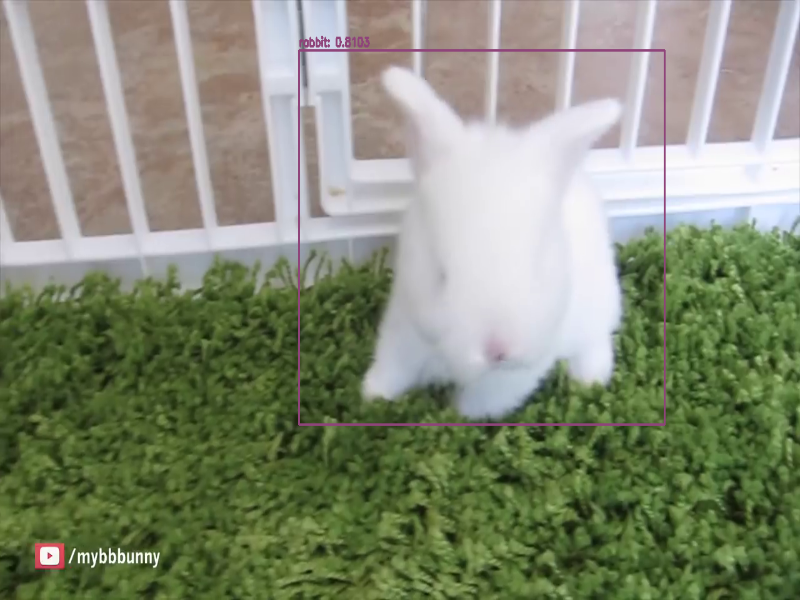

Frame number 3


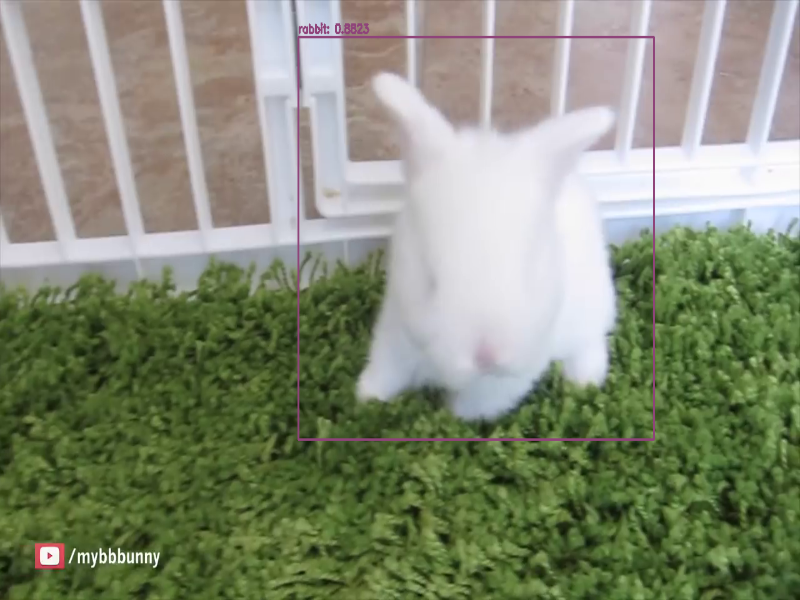

Frame number 4


Frame number 5


Frame number 6


Frame number 7


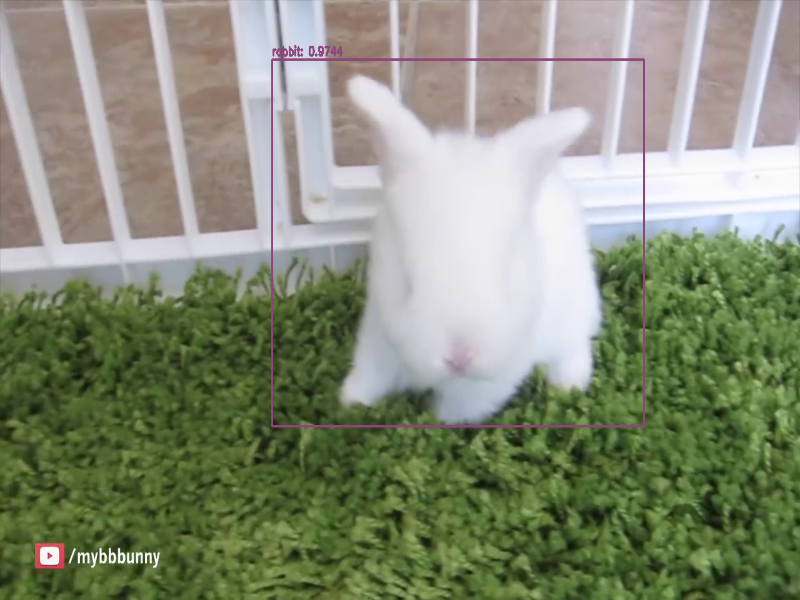

Frame number 8


Frame number 9


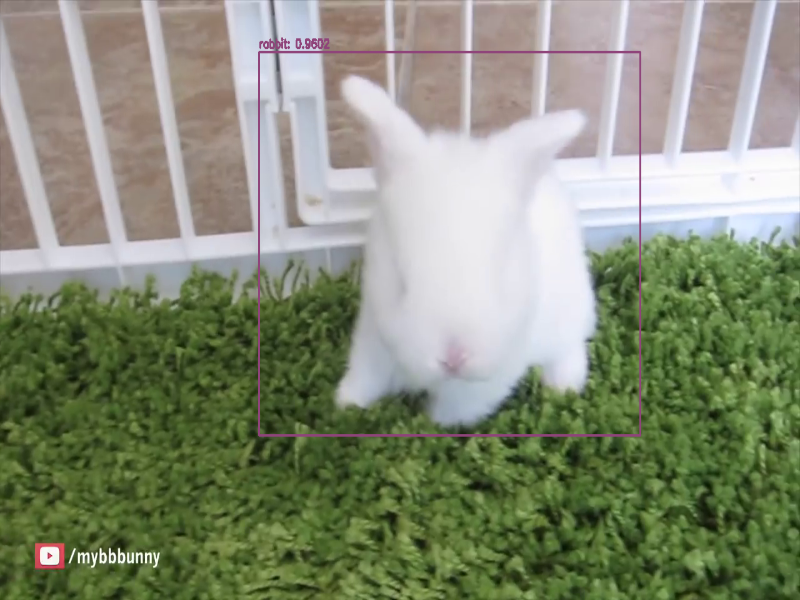

Frame number 10


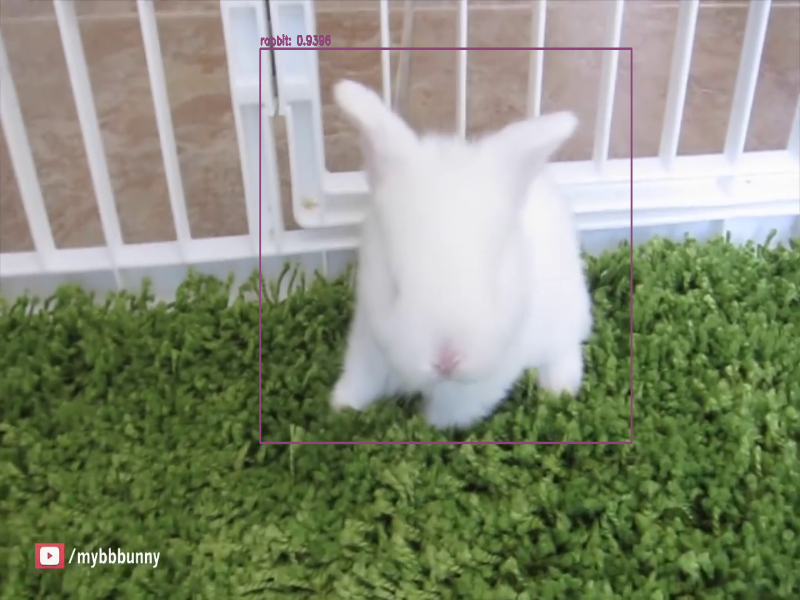

Frame number 11


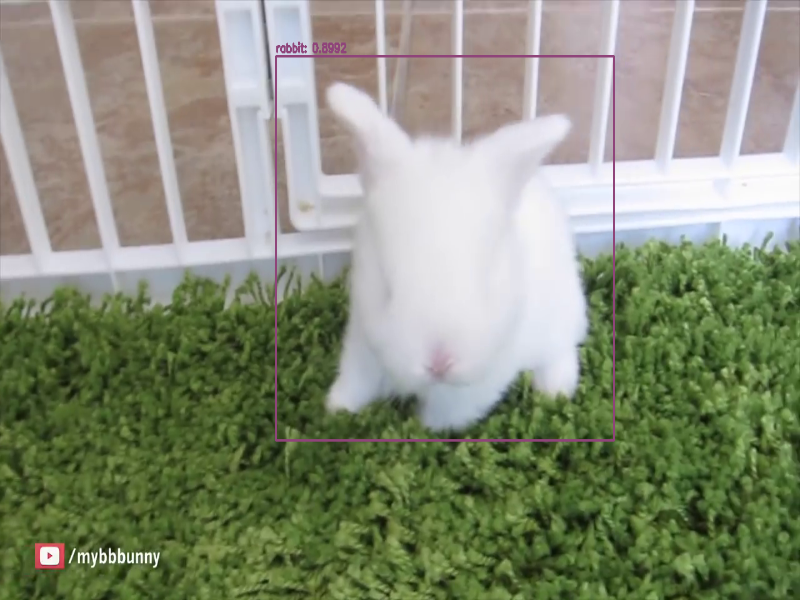

Frame number 12


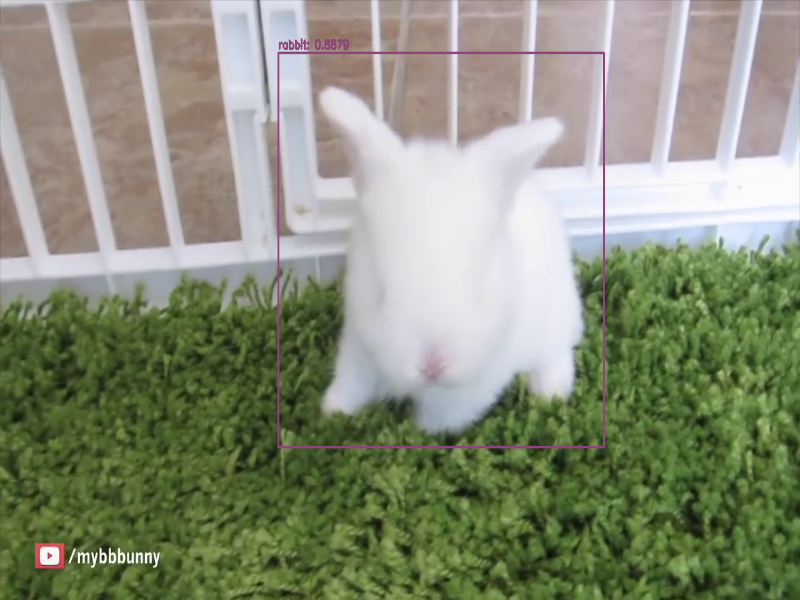

Frame number 13


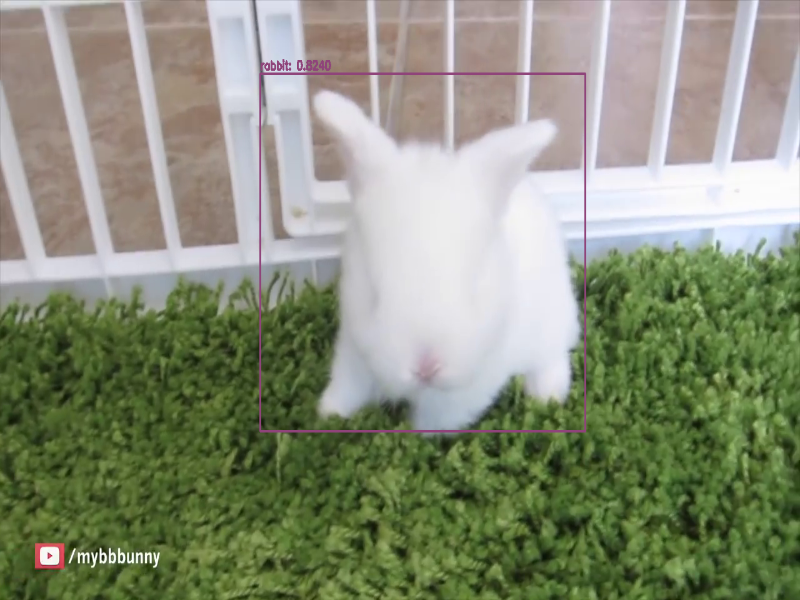

Frame number 14


In [ ]:
import numpy as np
import time
import cv2
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

from google.colab.patches import cv2_imshow

INPUT_FILE='Cutest little bunny prison break!.mp4'
OUTPUT_FILE='output.mp4'
LABELS_FILE='test.names'
CONFIG_FILE='yolov3_testing.cfg'
WEIGHTS_FILE='yolov3_training_last (5).weights'
CONFIDENCE_THRESHOLD=0.3

H=None
W=None

fps = FPS().start()

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30,
	(800, 600), True)

LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")


net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

vs = cv2.VideoCapture(INPUT_FILE)


# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
cnt =0;
while True:
	cnt+=1
	print ("Frame number", cnt)
	try:
		(grabbed, image) = vs.read()
	except:
		break
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
	net.setInput(blob)
	if W is None or H is None:
		(H, W) = image.shape[:2]
	layerOutputs = net.forward(ln)






	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability) of
			# the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > CONFIDENCE_THRESHOLD:
				# scale the bounding box coordinates back relative to the
				# size of the image, keeping in mind that YOLO actually
				# returns the center (x, y)-coordinates of the bounding
				# box followed by the boxes' width and height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top and
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates, confidences,
				# and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping bounding
	# boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
		CONFIDENCE_THRESHOLD)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			color = [int(c) for c in COLORS[classIDs[i]]]

			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, color, 2)

	# show the output image
	cv2_imshow(cv2.resize(image,(800, 600)))
	writer.write(cv2.resize(image,(800, 600)))
	fps.update()
	key = cv2.waitKey(1) & 0xFF
	if key == ord("q"):
		break

fps.stop()

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()